In [33]:
Query="What is MLflow"

In [34]:
from dotenv import load_dotenv

load_dotenv()


True

In [35]:
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

def process_pdf_batch(pdf_file):
    loader = PyPDFLoader(pdf_file)
    pages = loader.load_and_split()
    character_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=0
        )
    pages = character_splitter.split_documents(pages)
    return pages

In [36]:
d="sample"
chunks=process_pdf_batch(fr"data\{d}.pdf")

In [37]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=chunks, 
                                    embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [38]:
retriever.invoke(Query)

[Document(page_content='MLflow enables an everyday practitioner in one platform to manage the ML life cycle, \nfrom iteration on model development up to deployment in a reliable and scalable \nenvironment that is compatible with modern software system requirements.', metadata={'page': 20, 'source': 'data\\sample.pdf'}),
 Document(page_content='MLflow enables an everyday practitioner in one platform to manage the ML life cycle, \nfrom iteration on model development up to deployment in a reliable and scalable \nenvironment that is compatible with modern software system requirements.', metadata={'page': 20, 'source': 'data\\sample.pdf'}),
 Document(page_content="1\nIntroducing MLflow\nMLflow  is an open source platform for the machine learning (ML) life cycle, with a \nfocus on reproducibility , training , and deployment . It is based on an open interface design \nand is able to work with any language or platform, with clients in Python and Java, and \nis accessible through a REST API. Sc

In [39]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.load import dumps, loads

def generate_queries():
        
    # Multi Query: Different Perspectives
    template = """You are an AI language model assistant. Your task is to generate Four 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines. Original question: {question}"""
    prompt_perspectives = ChatPromptTemplate.from_template(template)


    generate_querie = (
        prompt_perspectives 
        | ChatOpenAI(temperature=0) 
        | StrOutputParser() 
        | (lambda x: x.split("\n"))
    )
    return generate_querie 


def _get_docs(m):
    docs=[]
    docs.extend(m['original'])
    for i in m['new']:
        docs.extend(i)
    return docs



In [40]:
from langchain_core.runnables import RunnableParallel
original_question= retriever
retrieval_chain =  generate_queries() | retriever.map()
map_chain = RunnableParallel(original=original_question,new=retrieval_chain) | _get_docs

In [41]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
embedding_function = SentenceTransformerEmbeddingFunction()

In [42]:
import numpy as np
import tqdm

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [43]:
import chromadb

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import numpy as np
from pypdf import PdfReader
from tqdm import tqdm


def _read_pdf(filename):
    reader = PdfReader(filename)
    
    pdf_texts = [p.extract_text().strip() for p in reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]
    return pdf_texts


def _chunk_texts(texts):
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts

def load_chroma(filename, collection_name, embedding_function):
    texts = _read_pdf(filename)
    chunks = _chunk_texts(texts)

    chroma_cliet = chromadb.Client()
    chroma_collection = chroma_cliet.create_collection(name=collection_name, embedding_function=embedding_function)

    ids = [str(i) for i in range(len(chunks))]

    chroma_collection.add(ids=ids, documents=chunks)

    return chroma_collection

In [44]:
chroma_collection = load_chroma(filename=fr'data\sample.pdf', collection_name='sample', embedding_function=embedding_function)
chroma_collection.count()

c:\Users\shyams\Downloads\RAG\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


438

In [45]:
import umap
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

c:\Users\shyams\Downloads\RAG\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 438/438 [07:37<00:00,  1.04s/it]


In [46]:
projected_dataset_embeddings

array([[12.6586237 ,  7.98261642],
       [12.78318024,  7.57137346],
       [11.31269264,  5.85169411],
       [11.23970509,  9.23397064],
       [ 8.95693016,  7.70492935],
       [ 9.94081306,  7.81140566],
       [ 8.74642849,  6.80665827],
       [11.15716743,  9.04938984],
       [14.38267422,  7.68552113],
       [13.56526852,  8.0137434 ],
       [12.33849812,  7.84965706],
       [12.46475506,  8.32644749],
       [12.20708847, 10.11478329],
       [12.41074467,  7.25959063],
       [12.97700596,  8.66182709],
       [11.39036274,  6.90323687],
       [13.01144886,  8.79320431],
       [13.04022312,  8.71345711],
       [12.96929359,  8.8367691 ],
       [12.86731148,  8.94399929],
       [12.11449718,  9.37308025],
       [11.68114471,  8.26427746],
       [12.96124458,  8.84537506],
       [12.39950085,  8.76408195],
       [ 9.37394047,  9.51047134],
       [12.82926178,  8.96147156],
       [12.7143116 ,  9.22272301],
       [11.41752052,  7.14634991],
       [12.40992069,

(6.546573162078857, 15.074453830718994, 4.177348017692566, 11.432156205177307)

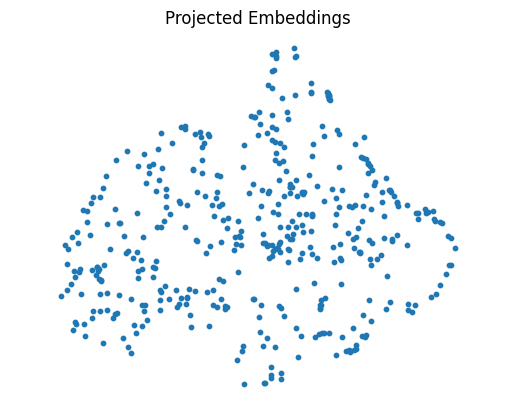

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [48]:

results = chroma_collection.query(query_texts=Query, n_results=5, include=['documents', 'embeddings'])

In [55]:
results['documents'][0]

['explore advanced concepts of mlflow in the last chapter of the book.',
 'further reading 139 further reading in order to further your knowledge, you can consult the documentation at the following link : https : / / github. com / mlflow / mlflow / blob / master / examples / multistep _ workflow / mlproject',
 'mlflow enables an everyday practitioner in one platform to manage the ml life cycle, from iteration on model development up to deployment in a reliable and scalable environment that is compatible with modern software system requirements.',
 'ml ecosystem for both engineers and data scientists. we will now delve into extending mlflow functionalities through plugins.',
 "1 introducing mlflow mlflow is an open source platform for the machine learning ( ml ) life cycle, with a focus on reproducibility, training, and deployment. it is based on an open interface design and is able to work with any language or platform, with clients in python and java, and is accessible through a rest 

In [49]:
query_embedding = embedding_function([Query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


(6.546573162078857, 15.074453830718994, 4.177348017692566, 11.432156205177307)

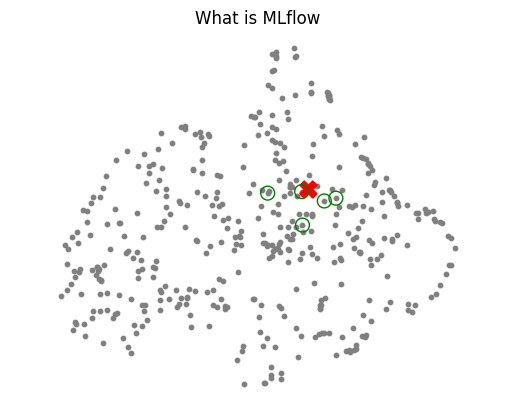

In [50]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{Query}')
plt.axis('off')

In [56]:
multiple_query=generate_queries()
d=multiple_query.invoke(Query)

In [57]:
for i in d:
    print(i)

1. Can you explain the concept of MLflow?
2. How would you define MLflow?
3. What are the key features of MLflow?
4. Could you provide an overview of MLflow and its functionalities?


In [58]:
queries = [Query] + d
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

In [59]:
original_query_embedding = embedding_function([Query])
augmented_query_embeddings = embedding_function(d)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


In [60]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


(6.546573162078857, 15.074453830718994, 4.177348017692566, 11.432156205177307)

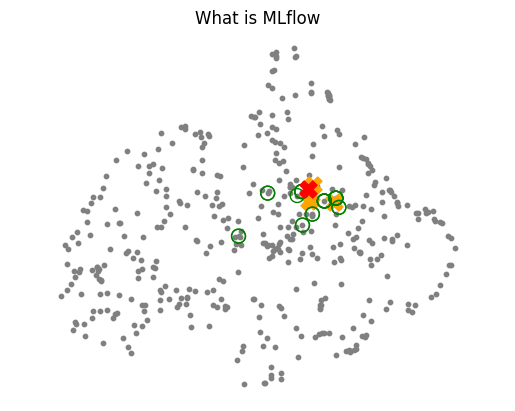

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{Query}')
plt.axis('off')